# makeEstimation_VAEwithDG.ipynb 이후 돌리기

- 모든 폴드의 결과를 하나로 합쳐서 평균 & 표준편차를 구하고 이를 그래프로 완성함

In [1]:
# import 필요한 라이브러리
import os
from os.path import join
from natsort import natsorted
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# 필요한 함수 선언
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [67]:
# 필요한 함수 정의
def axis3plot(position,data,name):
    color_X = "#e05858"
    color_Y = "#32a852"
    color_Z = "#4159cc"
    linewidth = 2
    
    subAJ_right = 0.5
    subAJ_top = 1.0
    subAJ_wspace = 0.5
    sub_offset= 40

    data = data.astype(float)
    
    host = host_subplot(position, axes_class=AA.Axes)
    
    plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = sub_offset
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",
                                        axes=par2,
                                        offset=(offset, 0))

    par1.axis["right"].toggle(all=True) 
    par2.axis["right"].toggle(all=True)

    # host.set_xlim(0, 2)
    # host.set_ylim(0, 2)

    host.set_xlabel(f"Normalized Time")
    host.set_title(
    f"{name}"
    )
    # host.set_ylabel("X_axis")
    # par1.set_ylabel("Y_axis")
    # par2.set_ylabel("Z_axis")

    p1, = host.plot(range(0,len(data)), np.array(data[:,0]), linewidth=linewidth,label="X_axis",color=color_X)
    host.fill_between(range(0,len(data)), np.array(data[:,0])+np.array(data[:,1]),np.array(data[:,0])-np.array(data[:,1]),alpha=0.2,facecolor=p1.get_color(), edgecolor=(0,0,0,.8))
    p2, = par1.plot(range(0,len(data)),  np.array(data[:,2]),linewidth=linewidth, label="Y_axis",color=color_Y)
    par1.fill_between(range(0,len(data)), np.array(data[:,2])+np.array(data[:,3]),np.array(data[:,2])-np.array(data[:,3]),alpha=0.2,facecolor=p2.get_color(),edgecolor=(0,0,0,.8))
    p3, = par2.plot(range(0,len(data)),  np.array(data[:,4]),linewidth=linewidth, label="Z_axis",color=color_Z)
    par2.fill_between(range(0,len(data)), np.array(data[:,4])+np.array(data[:,5]),np.array(data[:,4])-np.array(data[:,5]),alpha=0.2,facecolor=p3.get_color(),edgecolor=(0,0,0,.8))

    if 'angle' in name:
        host.set_ylim(0, 15)
        par1.set_ylim(0, 15)
        par2.set_ylim(0, 15)
    elif 'moBWHT' in name:
        host.set_ylim(0, 4)
        par1.set_ylim(0, 4)
        par2.set_ylim(0, 4)       

    host.legend()

    host.axis["left"].label.set_color(color_X)
    par1.axis["right"].label.set_color(color_Y)
    par2.axis["right"].label.set_color(color_Z)

    host.axis["left"].major_ticks.set_color(color_X)
    par1.axis["right"].major_ticks.set_color(color_Y)
    par2.axis["right"].major_ticks.set_color(color_Z)

    host.axis["left"].major_ticklabels.set_color(color_X)
    par1.axis["right"].major_ticklabels.set_color(color_Y)
    par2.axis["right"].major_ticklabels.set_color(color_Z)

In [71]:
# 본 결과를 담을 총 폴더 이름
motherDir = 'VAEwithDG'
# 사용 모델 및 데이터 이름
modelVersion = "DG_DenseRegressor_1st_torch" 
nameDataset = "IWALQQ_AE_1st"
# 사용한 feature압축용 VAE모델 이름
vae_ModelVersion = "vaelstm_3rd_torch"
sess = "angle"
emb_dim = 60
targetDir = join(motherDir,modelVersion,vae_ModelVersion,nameDataset,sess,str(emb_dim))
list_results = natsorted([_ for _ in os.listdir(targetDir) if _.endswith(".xlsx")])

for axe in ["X","Y","Z"]:
    globals()[f"total_{axe}"] = np.array([])
    for result in list_results:
        globals()[f"result_{axe}"]= pd.read_excel(join(targetDir,result),sheet_name=f'diff_{axe}').to_numpy()[:,1:]
        if len(globals()[f"total_{axe}"]) ==0:
            globals()[f"total_{axe}"] = globals()[f"result_{axe}"]
        else:
            globals()[f"total_{axe}"] = np.append(globals()[f"total_{axe}"], globals()[f"result_{axe}"],1)


    globals()[f"mean_{axe}"] = np.mean(globals()[f"total_{axe}"],1)[:,None]
    globals()[f"std_{axe}"] = np.std(globals()[f"total_{axe}"],1)[:,None]

# 축별 평균,표준편차 총 합 6개의 columns
total_result = np.concatenate([mean_X,std_X,mean_Y,std_Y,mean_Z,std_Z], axis=1)


In [72]:
motherDir = 'VAEwithDG'
# 사용 모델 및 데이터 이름
modelVersion = "DG_DenseRegressor_1st_torch" 
nameDataset = "IWALQQ_AE_1st"
# 사용한 feature압축용 VAE모델 이름
vae_ModelVersion = "vaelstm_3rd_torch"

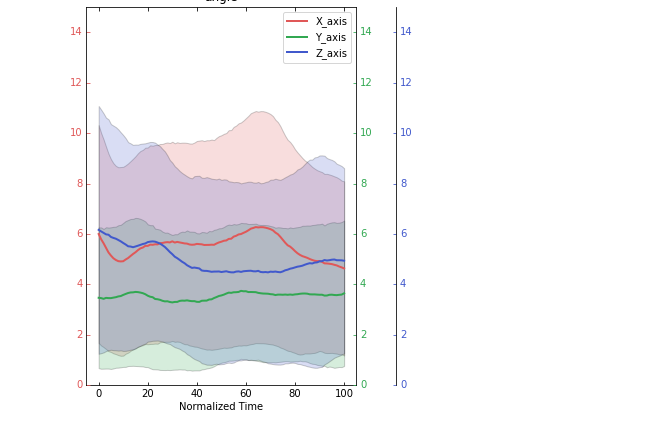

In [73]:
pp = PdfPages(join(targetDir,f"Total_result_{sess}.pdf"))
plt.figure(figsize=(10, 6))
axis3plot(111,total_result,f"{motherDir}\n{modelVersion}_\n{nameDataset}_{vae_ModelVersion}\n{sess}")
plt.tight_layout()
pp.savefig()
pp.close()